RasdaPy Tutorial
==
***
## Overview

### What is RasdaPy?
RasdaPy is a client API for rasdaman that enables building and executing rasql queries with python.

### How to get RasdaPy?
RasdaPy could be installed easily with [pip](https://pip.pypa.io/en/stable/installing/) from the official Python public libraries: https://pypi.python.org/pypi/rasdapy.


In [ ]:
pip install rasdapy

### What do I need before using RasdaPy?
* A running rasdaman instance, see: http://rasdaman.org/wiki/Download.
* A general idea about what is Rasdaman and how it works (**recommended for begginers**), see: http://tutorial.rasdaman.org/rasdaman-and-ogc-ws-tutorial/

## RasdaPy in actions

### Import RasdaPy core API
After RasdaPy installation, you can import RasdaPy to your Python script like others libraries.


In [22]:
from rasdapy.db_connector import DBConnector
from rasdapy.query_executor import QueryExecutor


### Initialize connection to **Rasdaman Manager** (rasmgr)
The DBConnector maintains the connection to rasdaman. In order to connect it is necessary to specify the host (*default: localhost*) and port (*default: 7001*) on which rasmgr is running, as well as valid rasdaman username with read and write permissions (*default: rasadmin*) and password (*default: rasadmin*).

In [43]:
db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
db_connector.open()

### Create the query executor
QueryExcutor is the interface through which rasql queries (*create, insert, update, delete, etc...*) are executed.

In [45]:
query_executor = QueryExecutor(db_connector)

### Returns a list of all the collections available in rasdaman
It is a good practice to check the connection to Rasdaman by this Rasql query and have an idea about which collections can be queries before-hand. Here, only 1 collection was created in Rasdaman, named **rgb**.

In rasdaman databases, arrays are grouped into *collections*. All elements of a collection share the same array type definition. Collections form the basis for array handling, just as tables do in relational databasetechnology. 

**Note**: We use *query_executor.execute_read()* because *SELECT* does not need the write permission in transaction to Rasdaman.

In [51]:
collection_list = query_executor.execute_read("select c from RAS_COLLECTIONNAMES as c")
print(collection_list)

['rgb']


### Create a new collection in Rasdaman
We want to create a new rasdaman collection using RasdaPy in this demonstration which can be used to query later. The collection is supposed to store a 2D PNG image with dataType: *char*.

**Note**: We use *query_executor.execute_write()* because *CREATE* needs the write permission in transaction to Rasdaman.

In [ ]:
query_executor.execute_write("create collection test_mr GreySet")

### Insert data from file to newly created collection
The collection is empty and we want to import data from a 2D PNG file as multi-dimensional array (**MDD**). You can download the input file from: http://rasdaman.org/browser/systemtest/testcases_mandatory/test_select/testdata/mr_1.png and save it to your local system which Rasdaman can *have permission to read*. In this tutorial, we save the file to: */home/rasdaman/mr.png*.

**Note**: We use *query_executor.execute_update_from_file()* because *INSERT* needs the write permission in transaction to Rasdaman and it is used to *INSERT/UPDATE* Rasdaman collections.

In [ ]:
query_executor.execute_update_from_file("insert into test_mr values decode($1)", "/home/rasdaman/mr.png")

### Check the spatial domain
When the *INSERT* query is successful, the MDD is created inside the collection *test_mr*. We can see the spatial domain (*width* x *height*) via this *SELECT* query:


In [30]:
sdom = query_executor.execute_read("select sdom(c) from test_mr as c")
print(sdom)

[0:255,0:210]


### Calculate the average of all values in collection
We want to get the average of all pixel values from test collection.

In [35]:
result = query_executor.execute_read("select (char)avg_cells(c) from test_mr as c")
print(result)

39


### Leverage the power of Numpy
Select a particular subset of array in collection *test_mr*. This query will return **raw array** data that can be converted to a *Numpy ndarray*. Then, you can do all the features of Numpy ndarray normally.

In [48]:
result = query_executor.execute_read("select m[0:10 ,0:10] from test_mr as m")
numpy_array = result.to_array()
print(numpy_array.shape)
print(numpy_array)


(11, 11)
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


### Display the output as 2D image
Using *matplotlib* library, you can display the *raw data* from Rasdaman as Numpy ndarray easily.

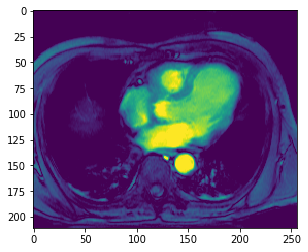

In [50]:
import matplotlib.pyplot as plt
import numpy as np

result = query_executor.execute_read("select m from test_mr as m")
numpy_array = result.to_array()

# Plot the grid
plt.imshow(numpy_array)
plt.show()

### Encode data and write to binary file
Rasdaman supports multilple type of encodes (e.g: jpeg, png, tiff, csv, json,...) so you can select data from Rasdaman with encoded format and write the result to a file normally (e.g: */tmp/output.png*).

In [40]:
result = query_executor.execute_read('select encode(m[0:10 ,0:10], "png") from test_mr as m')
with open("/tmp/output.png", "wb") as binary_file:
    binary_file.write(result.data)

### Close the connection to Rasdaman
It is important to close the connection to Rasdaman when you've finished your Python script. That will release the connection to *rasserver* and allow another client can connect to this server afterwards.


In [ ]:
db_connector.close()

## Conclusion

### Best practice
It is recommended to follow this template in order to avoid problems with leaked transactions:

In [ ]:
from rasdapy.db_connector import DBConnector
from rasdapy.query_executor import QueryExecutor

db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
query_executor = QueryExecutor(db_connector)

db_connector.open()

try:
    query_executor.execute_read("...")
    query_executor.execute_write("...")
    # ... more Python code
finally:
    db_connector.close()

### Development Warning
The Python implementation of Protocol Buffers is not as mature as the C++ and Java implementations. 
It may be more buggy, and it is known to be pretty slow at this time. Since this library relies heavily 
on Protocol Buffers and GRPC, it might be prone to occasional hiccups and unexpected behaviour.